# Forecasting Non-Farm Payrolls With Linear Regression 

## What Are Non-Farm Payrolls?

From all health of the labor market indicators in the United States, non-farm payrolls (NFP) is a crucial and frequently followed economic indicator. This monthly employment report, which does not include occupations in private households, NGOs, or the agricultural sector, offers a thorough overview of the employment situation in the United States. The NFP report reveals the net change in the total number of paid employees in the U.S., excluding the sectors mentioned above, in the previous month.

By analyzing the data, many people (economists, policymakers, and investors) can measure the health of the labor market, track employment trends, and make informed decisions regarding economic policies, investments, and hiring practices.

Let’s try to apply our model and see how it performs. We will evaluate our forecasts using the directional ratio and the RMSE. Here’s what they refer to:

- The directional ratio is simply a binary up or down measure that compares the number of the correct forecasts (NFP going up versus NFP going down) to the number of predictions.


- The RMSE stands for root mean squared error. It is a measure of the average magnitude of the errors between predicted and actual values in a dataset.

### Import Libraries

First we need to load the required libraries:

In [1]:
# Required libraries
import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Load and Transform the Data

In [2]:
#Load data from file
data = pd.read_excel('NFP.xlsx',header=None)
#Is everything ok with the libraries?
data.rename(columns={0: 'NFP'}, inplace=True)
print(data)

      NFP
0     177
1     180
2    -186
3     205
4     203
...   ...
1006  281
1007  105
1008  236
1009  227
1010  336

[1011 rows x 1 columns]


In [3]:
data.head()

,NFP
0,177
1,180
2,-186
3,205
4,203


In [4]:
#Flatten the data 
data = np.reshape(data, (-1))
data_flatten = data.flatten()

Takning the discrete rate of change from one point to the next.

In [5]:
data_diff = np.diff(data)
print(data_diff)

[   3 -366  391 ...  131   -9  109]


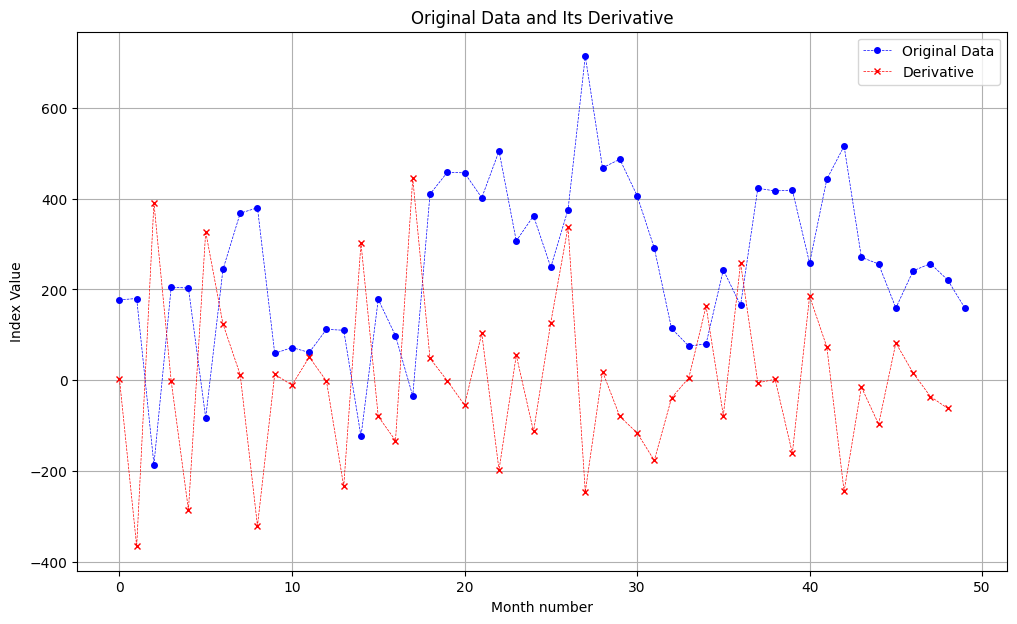

In [6]:
plt.figure(figsize=(12, 7))

#Plot flattened data
plt.plot(data_flatten[:50], marker='o', linestyle='--', color='blue', label='Original Data',
         linewidth=0.5, markersize=4)

#Plot derivative data
plt.plot(data_diff[:49], marker='x', linestyle='--', color='red', label='Derivative',
         linewidth=0.5, markersize=4)

plt.title('Original Data and Its Derivative')
plt.xlabel('Month number')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
data.sum()*100

14025800

In [8]:
nfp_accumulated = np.cumsum(data_flatten)

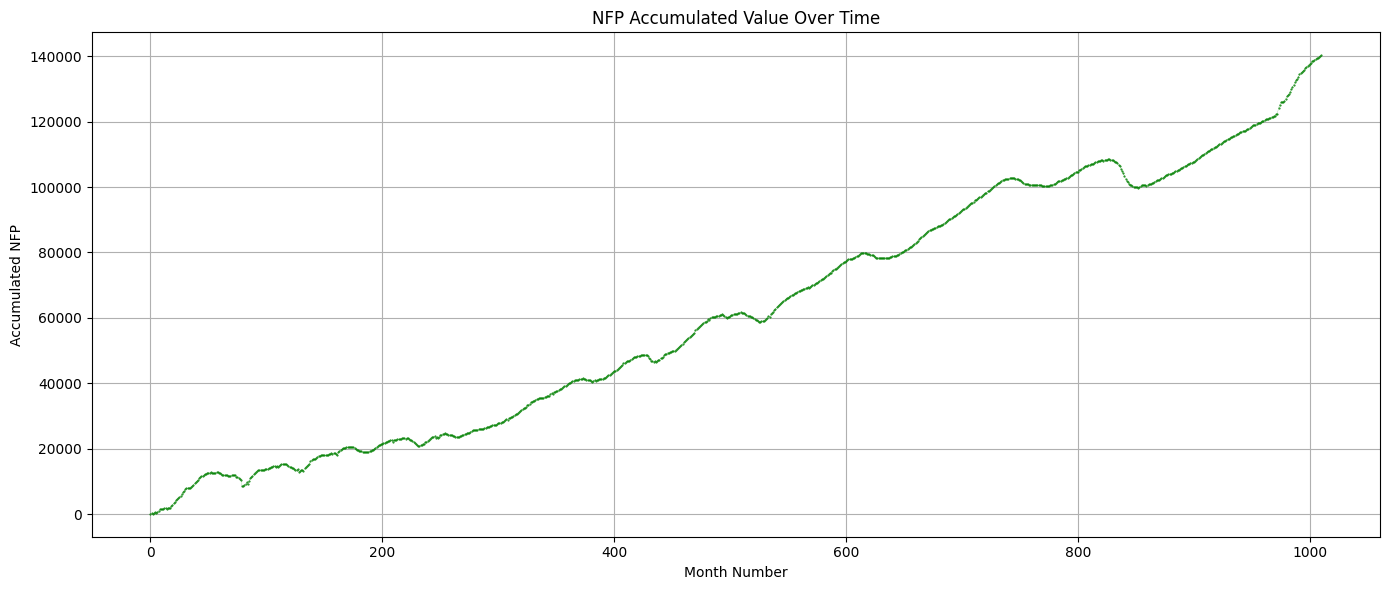

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(nfp_accumulated, marker='o', linestyle='-', color='green', lw=0.1, markersize=0.5)
plt.title("NFP Accumulated Value Over Time")
plt.xlabel("Month Number")
plt.ylabel("Accumulated NFP")
plt.grid(True)
plt.tight_layout()
plt.show()

### Data Processing

Now we need to split the data into train and test sets. We`ll train the LR model over the train dataset and test its performance over the test dataset.
Let's define a function to split the data:

In [10]:
def data_preprocessing(data, num_lags, train_test_split):
    """
    Prepare the time series data for model training by creating lagged versions of the dataset.
    
    This function takes a time series dataset, creates sequences of lagged observations
    (also known as the "sliding window" approach), and splits the data into training
    and testing sets. Each input sequence is a time window of `num_lags` consecutive observations,
    and the corresponding target is the subsequent observation.
    
    Parameters:
    - data (list or np.ndarray): The time series dataset (one-dimensional).
    - num_lags (int): The number of lagged observations to use for predicting the subsequent observation.
    - train_test_split (float): The proportion of the dataset to include in the training set. This should be
      a decimal representing the percentage (e.g., 0.8 for 80% training, 20% testing).
    
    Returns:
    - _x_train (np.ndarray): The input features for the training set.
    - _y_train (np.ndarray): The target values for the training set.
    - _x_test (np.ndarray): The input features for the testing set.
    - _y_test (np.ndarray): The target values for the testing set.
    
    Example:
    ```python
    # Example dataset of 100 observations
    data = np.arange(100)
    num_lags = 5
    train_test_split = 0.8
    x_train, y_train, x_test, y_test = data_preprocessing(data, num_lags, train_test_split)
    ```
    """
    
    #Prepare the data for training
    x = []
    y = []
    for i in range(len(data) - num_lags):
        x.append(data[i:i + num_lags])
        y.append(data[i+ num_lags])
        
    #Convert the data to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    #Split the data into training and testing setst
    split_index = int(train_test_split * len(x))
    _x_train = x[:split_index]
    _y_train = y[:split_index]
    _x_test = x[split_index:]
    _y_test = y[split_index:]
    return _x_train, _y_train, _x_test, _y_test 

In [11]:
#Data preprocessing & Splitting
x_train, y_train, x_test, y_test = data_preprocessing(data_diff, 5, 0.80)

In [12]:
print('Test set shape: ', x_test.shape)
print(x_test)

Test set shape:  (201, 5)
[[   3 -138 -135   45  113]
 [-138 -135   45  113  -28]
 [-135   45  113  -28  -30]
 ...
 [-224  -31    0   64 -176]
 [ -31    0   64 -176  131]
 [   0   64 -176  131   -9]]


### LR model

In [13]:
#Create a LR model
model = LinearRegression()

In [14]:
#Fit the model
model.fit(x_train, y_train)

LinearRegression()

In [15]:
# Predict on test data.
y_pred = model.predict(x_test)

#### Results and analysis

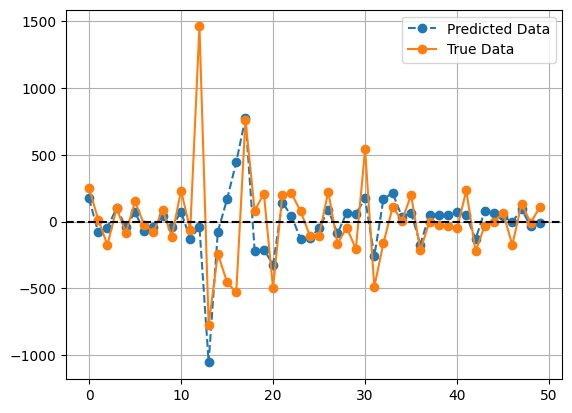

In [16]:
#Plot the original sine wave and the predicted values
plt.plot(y_pred[-50:], label='Predicted Data', linestyle='--', marker = 'o')
plt.plot(y_test[-50:], label='True Data', marker = 'o')
plt.legend()
plt.grid()
plt.axhline(y = 0, color = 'black', linestyle = '--')

In [17]:
#RMSE Calculation
rmse_test = math.sqrt(mean_squared_error(y_pred, y_test))
print(f"RMSE of Test: {rmse_test}")

RMSE of Test: 188.82810138089292


In [18]:
#Directional ratio calculation
same_sign_count = np.sum(np.sign(y_pred) == np.sign(y_test)) / len(y_test) * 100
print('Directional Ratio = ', same_sign_count, '%')
# Is this a good ratio? Why?

Directional Ratio =  69.65174129353234 %


In [19]:
x_test.std()

201.79774260033514

In [20]:
round(rmse_test/(x_test.max() - x_test.min())*100,2)

8.44

In [21]:
#Compute a simple baseline RMSE, using the mean of the actual values as constant prediction
baseline_preds = np.full(shape=y_test.shape, fill_value=y_test.mean())
baseline_rmse = np.sqrt(mean_squared_error(baseline_preds, y_test))
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 201.82749248885423


In [22]:
data_range = x_test.max()-x_test.min()

In [23]:
#Evaluation
print("Evaluation:")
if rmse_test < baseline_rmse:
    print("Your model performs better than the baseline model.")
else:
    print("Your model does not perform better than the baseline model. Consider improvements.")

if rmse_test / data_range < 0.1:
    print("RMSE is less than 10% of the data range. This is generally considered good.")
elif rmse_test / data_range < 0.2:
    print("RMSE is less than 20% of the data range. This may be acceptable depending on the application.")
else:
    print("RMSE is more than 20% of the data range. Consider this high depending on your application.")

Evaluation:
Your model performs better than the baseline model.
RMSE is less than 10% of the data range. This is generally considered good.
